# The purpose of this notebook is to make my first Neuronal Network. 

The notebook take like reference [this tutorial](https://www.youtube.com/watch?v=W8AeOXa_FqU&t=561s), although with some differences. 

## Import modules

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output

%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


One need to produce the dataset.

In [3]:
def get_circle_dataset(Npunt,rmin1,rmax1,rmin2,rmax2,nor,x0,y0,noisemin,noisemax):
    circle_x = x0                          # para fijar el centro del circulo
    circle_y = y0                          #
    L=nor
    N=Npunt
    np.random.seed(123)
    phi = 2. * np.pi * np.random.rand(N)
    nmin = noisemin
    nmax = noisemax

    ranillo = L * np.random.uniform(rmin1,rmax1,N)
    rani = np.sqrt(ranillo)
    x1 = rani * np.cos(phi) + np.random.uniform(nmin,nmax,N) + circle_x
    y1 = rani * np.sin(phi) + np.random.uniform(nmin,nmax,N) + circle_y

    rani2 = np.sqrt(4*L*np.random.uniform(rmin2,rmax2,N))
    x2 = rani2 * np.cos(phi) + np.random.uniform(nmin,nmax,N) +  circle_x
    y2 = rani2 * np.sin(phi) + np.random.uniform(nmin,nmax,N) +  circle_y
    
    x = np.hstack((x1,x2)) # shape (1000,)
    y = np.hstack((y1,y2)) #
    X = np.vstack((x,y)).T
    
    Y1 = np.ones((500,1),dtype=int)
    Y2 = np.zeros((500,1),dtype=int)
    Y = np.vstack((Y1,Y2))
    
    Z = np.hstack((X,Y))
    Zc = np.copy(Z)
    np.random.shuffle(Zc)
    X, Y = np.array_split(Zc,2,axis=1)
    return X, Y

In [4]:
X, Y = get_circle_dataset(500,0.,1.,1.,1.5,0.25,0.,0.,0.,0.4)

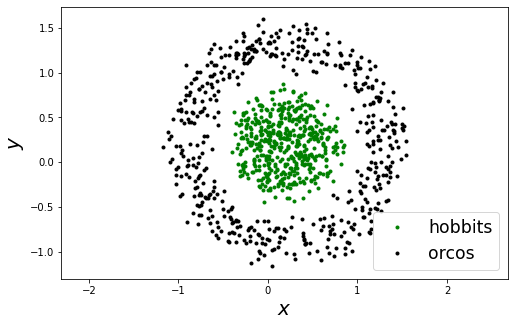

In [5]:
plt.figure(figsize=(8,5))
plt.plot(X[Y[:,0] ==1,0], X[Y[:,0]==1,1],'.', color = 'g', label = 'hobbits')
plt.plot(X[Y[:,0]==0,0], X[Y[:,0]==0,1],'.', color = 'k', label = 'orcos')
plt.axis('equal')
plt.xlabel('$x$', fontsize = 20)
plt.ylabel('$y$', fontsize = 20)
plt.legend(fontsize='xx-large')

In [6]:
class neural_layer():
    ### Number of connections, number of neuron, activation function.
    def __init__(self, n_conn, n_neur, act_fun):
        self.act_fun = act_fun
        ### Inicializar parametros de la capa (bias, weight)
        self.b = np.random.rand(1,n_neur)*2 - 1 # num. aleatorios entre -1 y 1
        self.w = np.random.rand(n_conn, n_neur)*2 - 1

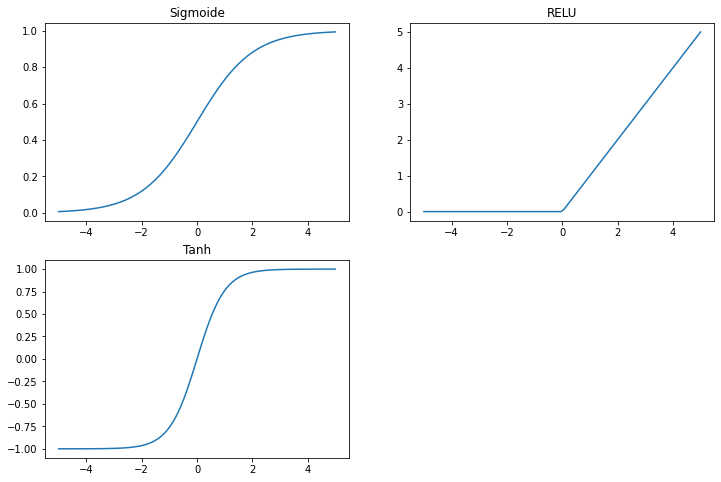

In [7]:
### Sigmoide
sigm = (lambda x: 1 / (1 + np.exp(-x)), lambda x: x*(1-x)) # funcion de activacion y su derivada.
### relu
relu = lambda x: np.maximum(0,x)
### hyperbolic tangent
tanh = lambda x: np.tanh(x)
### Plotting
xx = np.linspace(-5,5,100)
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.title('Sigmoide')
plt.plot(xx,sigm[0](xx))
plt.subplot(2,2,2)
plt.title('RELU')
plt.plot(xx,relu(xx))
plt.subplot(2,2,3)
plt.title('Tanh')
plt.plot(xx,tanh(xx))

In [9]:
def create_nn(topology, act_f):
    nn = [] ### vector que contiene la informacion de las capas
    for l, layer in enumerate(topology[:-1]):
        nn.append(neural_layer(topology[l],topology[l+1], act_f))
    return nn

In [10]:
p = 2
#topology = (p,4,8,1)
topology = (p,128,24,10,1)
neural_net = create_nn(topology,sigm)

In [11]:
neural_net

In [12]:
### Funcion de coste (valor predicho, valor real). Se necesita el coste y su derivada
fcost = (lambda Yp, Yr: np.mean((Yp - Yr)**2), lambda Yp, Yr: (Yp - Yr))

def train(neural_net, X, Y, fcost, lr = 0.01, train = True):
    out = [(None, X)]  # se guardara la suma ponderada y la activacion
    ### Forward pass
    for l, layer in enumerate(neural_net):
        z = out[-1][1] @ neural_net[l].w + neural_net[l].b # suma ponderada
        a = neural_net[l].act_fun[0](z)                    # activacion
        out.append((z,a))
    #print(fcost[0](out[-1][1],Y)) # solo para ver una prediccion, pero no el entrenemiento.
    if train:
        # Backward pass
        delta = []
        for l in reversed(range(0,len(neural_net))):
            z = out[l+1][0]
            a = out[l+1][1]
            if l==len(neural_net) - 1: # -1 porque los indices empiezan en 0, lo que significa que estamos en la ultima capa
                #calcular delta de la ultima capa
                delta.insert(0,fcost[1](a,Y) * neural_net[l].act_fun[1](a))
            
            else:
                #calcular delta respecto a capa previa
                delta.insert(0, delta[0] @ ww.T * neural_net[l].act_fun[1](a))
            ww = neural_net[l].w
            # Gradient descent
            neural_net[l].b = neural_net[l].b - np.mean(delta[0],axis=0,keepdims=True) * lr
            neural_net[l].w = neural_net[l].w - out[l][1].T @ delta[0] * lr
    return out[-1][1]

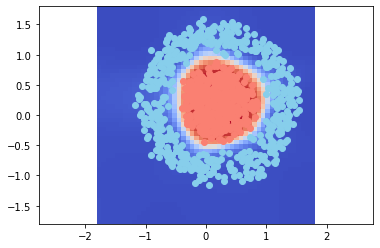

In [13]:
neural_n = create_nn(topology, sigm)

loss = []  # guardar los diferentes costes y ver como cambia con el tiempo
plt.figure(figsize=(14,7))
for i in range(180):
    # Entrenemos la red
    pY = train(neural_n, X, Y, fcost)
    if i % 1 ==0:
        loss.append(fcost[0](pY,Y))
        
        res = 50 
        
        x0 = np.linspace(-1.8,1.8,res)
        x1 = np.linspace(-1.8,1.8,res)
        
        yy = np.zeros((res,res))
        
        for j, k in enumerate(x0):
            for jj, kk in enumerate(x1):
                yy[j,jj] = train(neural_n, np.array([[k,kk]]), Y, fcost, train=False)[0][0]
        #plt.subplot(1,2,1)
        plt.pcolormesh(x0,x1,yy,cmap='coolwarm')
        plt.axis('equal')
        
        plt.scatter(X[Y[:,0]==0,0], X[Y[:,0]==0,1], c='skyblue')
        plt.scatter(X[Y[:,0]==1,0], X[Y[:,0]==1,1], c='salmon')
        
        clear_output(wait=True)
        plt.show()
        #plt.subplot(1,2,2)
        #plt.plot(range(len(loss)),loss)
        #plt.show()
        time.sleep(0.01)

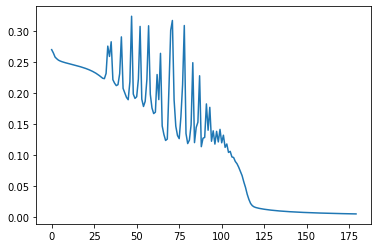

In [14]:
plt.plot(range(len(loss)),loss)

In [16]:
loss

[0.2698479774273678,
 0.26449490709019685,
 0.25787301942898877,
 0.2551116789712991,
 0.25285888504363013,
 0.251543635157186,
 0.2504595999972547,
 0.24957543809990795,
 0.2487649810441419,
 0.24800739854419954,
 0.24727838939065577,
 0.24656819874064245,
 0.24586631224816238,
 0.24516384929164098,
 0.2444513228420295,
 0.24372039567937864,
 0.24296219260613372,
 0.24216899395925326,
 0.24133199890192045,
 0.2404431056352273,
 0.23949241035196878,
 0.23847017166600432,
 0.23736405841344121,
 0.23616134007707293,
 0.23484561415809982,
 0.23339902872666818,
 0.2317983002570615,
 0.23001672238211734,
 0.2280280693573862,
 0.22583467642331778,
 0.22368670577405714,
 0.22301386285315078,
 0.23139722018683964,
 0.27556454239501565,
 0.25885590527496655,
 0.2825764570551225,
 0.22133035449585148,
 0.215694082347801,
 0.2117750618370538,
 0.2133191967110284,
 0.23110127753705761,
 0.29046814395842097,
 0.2073108315112885,
 0.2000779049791028,
 0.1927204211211131,
 0.18902040008617332,
 0.218